In [10]:
import timeit
from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator
from qulacs.gate import H, CNOT, RX, RZ
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

最適化後の値: -0.49999999999882094
最適化後の(beta, gamma): [1.26305645 0.30774029]


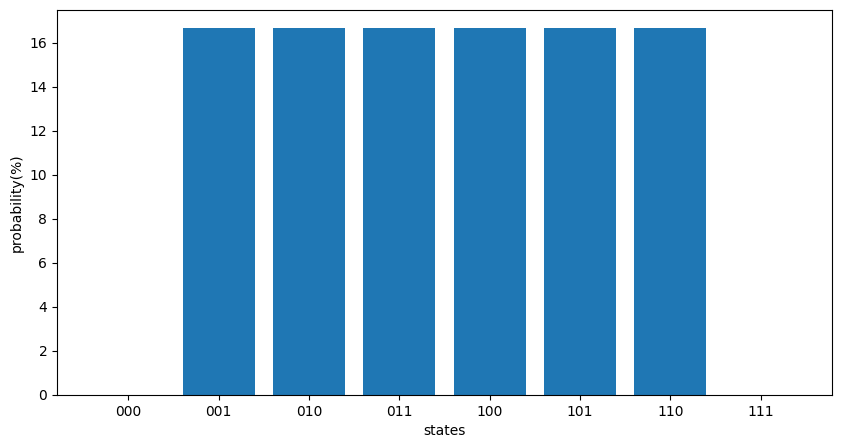

初期化時間: 0.000358 秒
最適化時間: 0.003044 秒
状態ベクトル計算時間: 0.000175 秒
0.0035777919983956963


In [303]:
start_time = timeit.default_timer()

## 頂点の数
n = 3

## C(Z)をqulacs.Observableとして定義
cost_observable = Observable(n)
for i in range(n):
    cost_observable.add_operator(PauliOperator("Z {:} Z {:}".format(i, (i+1)%n), 0.5))

# circuit に U_C(gamma) を加える関数
def add_U_C(circuit, gamma):
    for i in range(n):
        j = (i+1) % n
        circuit.add_CNOT_gate(i, j)
        circuit.add_gate(RZ(j, -2*gamma))  ## qulacsでは RZ(theta)=e^{i*theta/2*Z}
        circuit.add_CNOT_gate(i, j)
    return circuit

# circuit に U_X(beta) を加える関数
def add_U_X(circuit, beta):
    for i in range(n):
        circuit.add_gate(RX(i, -2*beta))
    return circuit

# p=1 の |beta, gamma> を作って <beta, gamma| C(Z) |beta, gamma> を返す関数
# x = [beta, gamma]
def QAOA_output_onelayer(x):
    beta, gamma = x

    circuit = QuantumCircuit(n)
    ## 重ね合わせを作るため、アダマールゲートをかける
    for i in range(n):
        circuit.add_H_gate(i)
    ## U_C, U_Xをかける
    circuit = add_U_C(circuit, gamma)
    circuit = add_U_X(circuit, beta)

    ## |beta, gamma>を作る
    state = QuantumState(n)
    state.set_zero_state()
    circuit.update_quantum_state(state)
    return cost_observable.get_expectation_value(state)

# 初期化時間の終了
init_time = timeit.default_timer() - start_time

# 初期値
x0 = np.array([0.1, 0.1])

# 最適化時間の計測
start_time = timeit.default_timer()

## scipy.minimize を用いて最小化
result = minimize(QAOA_output_onelayer, x0, options={'maxiter': 500}, method='powell')

# 最適化時間の終了
optimization_time = timeit.default_timer() - start_time

print("最適化後の値:", result.fun)  # 最適化後の値
print("最適化後の(beta, gamma):", result.x)  # 最適化後の(beta, gamma)

# 最適なbeta, gammaを使って |beta, gamma> をつくる
beta_opt, gamma_opt = result.x

# 状態ベクトル計算時間の計測
start_time = timeit.default_timer()

circuit = QuantumCircuit(n)
## 重ね合わせを作るため、アダマールゲートをかける
for i in range(n):
    circuit.add_H_gate(i)
## U_C, U_Xをかける
circuit = add_U_C(circuit, gamma_opt)
circuit = add_U_X(circuit, beta_opt)

## |beta, gamma>を作る
state = QuantumState(n)
state.set_zero_state()
circuit.update_quantum_state(state)

# 状態ベクトル計算時間の終了
state_vector_time = timeit.default_timer() - start_time

## z方向に観測した時の確率分布を求める. (状態ベクトルの各成分の絶対値の二乗=観測確率)
probs = np.abs(state.get_vector())**2

# プロットする
%matplotlib inline
## z方向に射影測定した時に得られる可能性があるビット列
z_basis = [format(i, "b").zfill(n) for i in range(probs.size)]

plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis, probs*100)
plt.show()

# 実行時間の出力
print("初期化時間: {:.6f} 秒".format(init_time))
print("最適化時間: {:.6f} 秒".format(optimization_time))
print("状態ベクトル計算時間: {:.6f} 秒".format(state_vector_time))
print(init_time+optimization_time+state_vector_time)


最適化後の値: -3.9999997634892774
最適化後の[beta0, beta1, gamma0, gamma1]: [0.94930374 1.2428437  0.32789421 0.62136125]


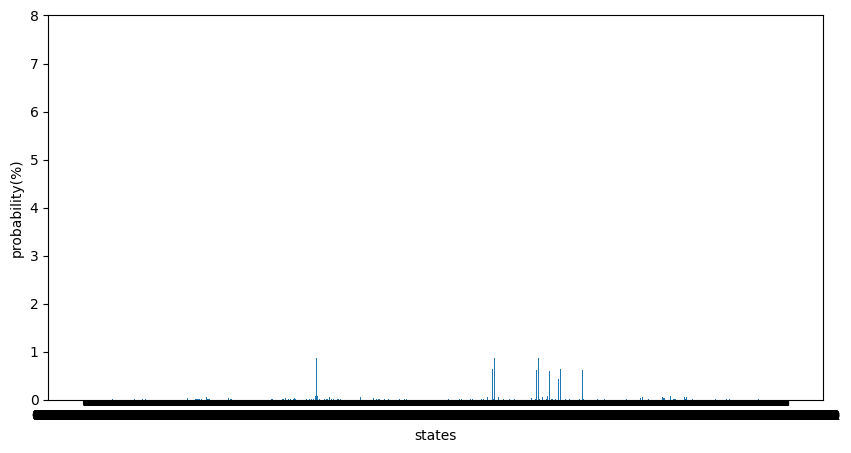

初期化時間: 0.000646 秒
最適化時間: 0.212037 秒
状態ベクトル計算時間: 0.001267 秒
0.2139498750002531


In [395]:
# 初期化時間の計測
start_time = timeit.default_timer()

# 頂点の数
n = 12

# C(Z)をqulacs.Observableとして定義
cost_observable = Observable(n)
for i in range(n):
    cost_observable.add_operator(PauliOperator("Z {:} Z {:}".format(i, (i+1)%n), 0.5))

# circuit に U_C(gamma) を加える関数
def add_U_C(circuit, gamma):
    for i in range(n):
        j = (i+1) % n
        circuit.add_CNOT_gate(i, j)
        circuit.add_gate(RZ(j, -2*gamma))  # qulacsでは RZ(theta)=e^{i*theta/2*Z}
        circuit.add_CNOT_gate(i, j)
    return circuit

# circuit に U_X(beta) を加える関数
def add_U_X(circuit, beta):
    for i in range(n):
        circuit.add_gate(RX(i, -2*beta))
    return circuit

# p=2 の |beta, gamma> を作って <beta, gamma| C(Z) |beta, gamma> を返す関数
# x = [beta0, beta1, gamma0, gamma1]
def QAOA_output_twolayer(x):
    beta0, beta1, gamma0, gamma1 = x

    circuit = QuantumCircuit(n)
    # 重ね合わせを作るため、アダマールゲートをかける
    for i in range(n):
        circuit.add_H_gate(i)
    # U_C, U_Xをかける
    circuit = add_U_C(circuit, gamma0)
    circuit = add_U_X(circuit, beta0)
    circuit = add_U_C(circuit, gamma1)
    circuit = add_U_X(circuit, beta1)

    # |beta, gamma>を作る
    state = QuantumState(n)
    state.set_zero_state()
    circuit.update_quantum_state(state)
    return cost_observable.get_expectation_value(state)

# 初期化時間の終了
init_time = timeit.default_timer() - start_time

# 初期値
x0 = np.array([0.1, 0.1, 0.2, 0.3])

# 最適化時間の計測
start_time = timeit.default_timer()

# scipy.minimize を用いて最小化
result = minimize(QAOA_output_twolayer, x0, options={'maxiter': 500}, method='powell')

# 最適化時間の終了
optimization_time = timeit.default_timer() - start_time

print("最適化後の値:", result.fun)  # 最適化後の値
print("最適化後の[beta0, beta1, gamma0, gamma1]:", result.x)  # 最適化後の[beta0, beta1, gamma0, gamma1]

# 最適化後の状態を測定した時の確率分布を調べる
beta0, beta1, gamma0, gamma1 = result.x

# 状態ベクトル計算時間の計測
start_time = timeit.default_timer()

circuit = QuantumCircuit(n)
# 重ね合わせを作るため、アダマールゲートをかける
for i in range(n):
    circuit.add_H_gate(i)
# U_C, U_Xをかける
circuit = add_U_C(circuit, gamma0)
circuit = add_U_X(circuit, beta0)
circuit = add_U_C(circuit, gamma1)
circuit = add_U_X(circuit, beta1)

# |beta, gamma>を作る
state = QuantumState(n)
state.set_zero_state()
circuit.update_quantum_state(state)

# 状態ベクトル計算時間の終了
state_vector_time = timeit.default_timer() - start_time

# 状態ベクトルの各成分の絶対値の二乗=観測確率
probs = np.abs(state.get_vector())**2

# z方向に射影測定した時に得られる可能性があるビット列
z_basis = [format(i, "b").zfill(n) for i in range(probs.size)]

plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis, probs*100)
plt.show()

# 実行時間の出力
print("初期化時間: {:.6f} 秒".format(init_time))
print("最適化時間: {:.6f} 秒".format(optimization_time))
print("状態ベクトル計算時間: {:.6f} 秒".format(state_vector_time))
print(init_time+optimization_time+state_vector_time)
